<a href="https://colab.research.google.com/github/ParadoxicalNerd/CS448-Style-Transfer/blob/main/Functional_Implementation_(Success).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

from copy import deepcopy
from tqdm.notebook import tqdm
from time import sleep

import requests

In [ ]:
%matplotlib inline
np.random.seed(0)
torch.manual_seed(0)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# content_path='/content/drive/My Drive/Colab Notebooks/Neural Image Style Transfer/Input Images/dancing.jpg'
# style_path='/content/drive/My Drive/Colab Notebooks/Neural Image Style Transfer/Input Images/picasso.jpg'
# content_path='/content/drive/My Drive/Colab Notebooks/Neural Image Style Transfer/Input Images/birdie.jpg'
# style_path='/content/drive/My Drive/Colab Notebooks/Neural Image Style Transfer/Input Images/StarryNight.jpg'
# style_path=requests.get('https://i.pinimg.com/564x/c1/2f/18/c12f189dfc84589d8db8c64b693b7c32.jpg', stream=True).raw

content_path='content.jpg'
style_path='style.webp'

transformer=transforms.Compose([
                                transforms.Resize(512),
                                transforms.CenterCrop(512),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406],
                                                    [0.229, 0.224, 0.225])
                            ])
def image_loader(image_path):
    image=Image.open(image_path)
    image=transformer(image).unsqueeze(0)
    return image.to(device)

content_image=image_loader(content_path)
style_image=image_loader(style_path)

In [ ]:
model = models.vgg19(pretrained=True).features

for p in model.parameters():
    p.requires_grad = False

model=model.to(device)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


In [ ]:
layers = {
        '0' : 'conv1_1',
        '5' : 'conv2_1',
        '10': 'conv3_1',
        '19': 'conv4_1',
        '21': 'conv4_2',
        '28': 'conv5_1'
    }

style_weights = {
        "conv1_1" : 1.0,
        "conv2_1" : 1.0,
        "conv3_1" : 1.0,
        "conv4_1" : 1.0,
        "conv5_1" : 1.0
    }

def model_activations(input,model):
    features = {}
    for name,layer in model._modules.items():
        input=layer(input)
        if name in layers:
            features[layers[name]] = input
    return features

In [ ]:
def content_loss(content_features, target_features):
    loc='conv4_2'
    return nn.functional.mse_loss(content_features[loc], target_features[loc])

def gram_matrix(matrix):
    k,dimensions,height,width = matrix.size()
    matrix = matrix.view(k*dimensions, height*width)
    return torch.mm(matrix,matrix.t())

def style_loss(style_features, target_features, model):
    style_loss = 0
    for layer in style_weights:
        _,d,w,h = target_features[layer].shape
        target_gram=gram_matrix(target_features[layer])
        style_gram=gram_matrix(style_features[layer])

        style_loss += (style_weights[layer]*nn.functional.mse_loss(target_gram, style_gram))/d*w*h
    return style_loss

def total_loss(content_features, style_features, content_weight, style_weight, target_features, model):
    return content_weight * content_loss(content_features, target_features) + \
            style_weight * style_loss(style_features, target_features, model)

In [ ]:
target_image = content_image.clone().requires_grad_(True).to(device)

content_weight=1
style_weight=1e7
lr=0.1

epochs=1000
optimizer=torch.optim.Adam([target_image], lr)

save_epochs=1000

content_features=model_activations(content_image, model)
style_features=model_activations(style_image, model)

In [ ]:
losses=[]

img_save=[]

for i in tqdm(range(epochs)):
    target_features=model_activations(target_image, model)

    loss=total_loss(
        content_features, style_features, content_weight, style_weight,
        target_features, model
    )
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if  (i%save_epochs==0):
        img_save.append(target_image.detach().clone())

    losses.append(loss)

In [ ]:
# for img_dat in img_save:
#     plt.figure()
#     plt.imshow(image_viewer(img_dat))
# plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


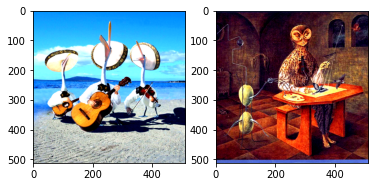

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


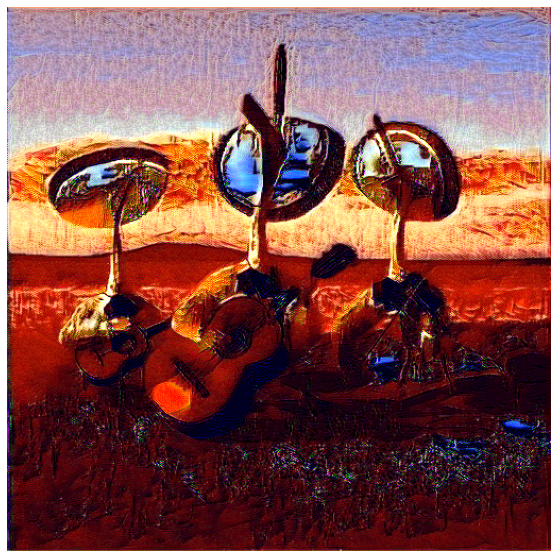

In [ ]:
def image_viewer(image):
    x = image.to("cpu").clone().detach().squeeze(0)
    x = x.numpy().transpose(1,2,0)
    x = x*np.array((0.5,0.5,0.5)) + np.array((0.5,0.5,0.5))
    # x=transforms.ToPILImage()(x)
    return x

fig, (ax1,ax2) = plt.subplots(1,2)
ax1.imshow(image_viewer(content_image),label = "Content")
ax2.imshow(image_viewer(style_image),label = "Style")
plt.show()

plt.figure(figsize=(20,10))
plt.imshow(image_viewer(target_image))
# plt.title('Target')
plt.axis('off')
plt.show()

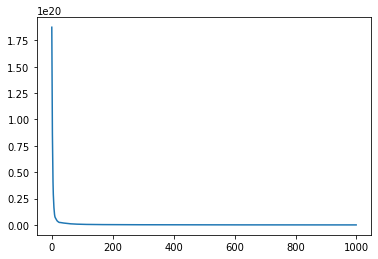

In [ ]:
plt.plot(np.arange(len(losses)), losses)

In [ ]:
content_image.shape

torch.Size([1, 3, 512, 512])